In [ ]:
# Cell 0 — environment check
import sys, os, torch
print("Python:", sys.version.split()[0])
print("Torch:", torch.__version__, "CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
try:
    import transformers, datasets, accelerate
    print("Transformers:", transformers.__version__)
    print("Datasets:", datasets.__version__)
    print("Accelerate:", accelerate.__version__)
except Exception as e:
    print("Some libs missing or incompatible:", e)


Python: 3.11.13
Torch: 2.6.0+cu124 CUDA available: True
GPU: Tesla T4
Transformers: 4.53.3
Datasets: 4.4.1
Accelerate: 1.9.0


In [ ]:
# Cell 1 — config
from pathlib import Path
import random
import numpy as np
import torch

# --- Paths ---
DATA_CSV = "/kaggle/input/depression/Depression_Severity_Levels_Dataset.csv"  # your uploaded file
DATA_DIR = Path("/kaggle/working/data")
DATA_DIR.mkdir(parents=True, exist_ok=True)
SAVED_MODELS = Path("/kaggle/working/models")
SAVED_MODELS.mkdir(parents=True, exist_ok=True)

# --- Reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# --- Training config (tweakable) ---
# --- Training config ---
MODEL_NAME = "microsoft/deberta-v3-large"   # upgrade to large
MAX_LEN = 256                                # keep (your diagnostics say so)
PER_DEVICE_TRAIN_BATCH_SIZE = 4              # fits T4
PER_DEVICE_EVAL_BATCH_SIZE = 8
GRADIENT_ACCUMULATION_STEPS = 2              # required for large model
NUM_EPOCHS = 4                                # recommended
LEARNING_RATE = 1.5e-5                        # slightly higher LR
WEIGHT_DECAY = 0.01
FP16 = True                                   # MUST keep True for large model


print("Config summary")
print("DATA_CSV:", DATA_CSV)
print("MODEL_NAME:", MODEL_NAME)
print("MAX_LEN:", MAX_LEN)
print("BATCH SIZE (per device):", PER_DEVICE_TRAIN_BATCH_SIZE)


Config summary
DATA_CSV: /kaggle/input/depression/Depression_Severity_Levels_Dataset.csv
MODEL_NAME: microsoft/deberta-v3-large
MAX_LEN: 256
BATCH SIZE (per device): 4


Text dataset shape: (41859, 3)

Label distribution:


label
severe      11176
mild        10661
minimum     10549
moderate     9473
Name: count, dtype: int64

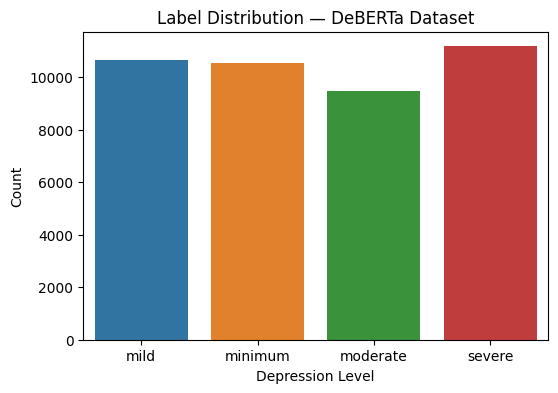

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


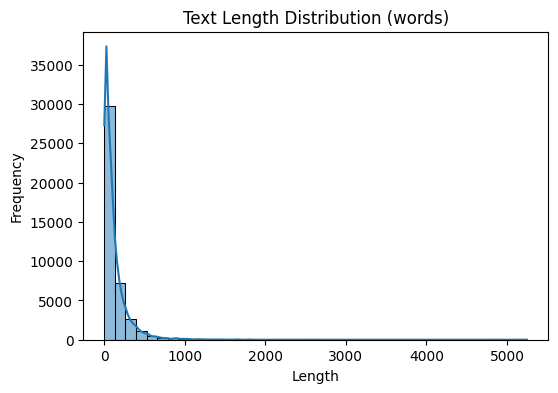

In [ ]:
# Cell R1 — Text Dataset Summary

import matplotlib.pyplot as plt
import seaborn as sns

print("Text dataset shape:", df.shape)
print("\nLabel distribution:")
display(df['label'].value_counts())

df['text_len'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label', order=sorted(df['label'].unique()))
plt.title("Label Distribution — DeBERTa Dataset")
plt.xlabel("Depression Level")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df['text_len'], bins=40, kde=True)
plt.title("Text Length Distribution (words)")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Cell 2 — load & stratified split
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv(DATA_CSV)
print("Original shape:", df.shape)
df = df.dropna(subset=["text","label"]).reset_index(drop=True)
df['label'] = df['label'].astype(str).str.strip()

# create numeric label ids
label_list = sorted(df['label'].unique())
label2id = {lab:i for i,lab in enumerate(label_list)}
id2label = {i:lab for lab,i in label2id.items()}
df['label_id'] = df['label'].map(label2id)

# stratified splits: train 80% val 10% test 10%
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label_id'], random_state=SEED)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label_id'], random_state=SEED)

train_df.to_csv(DATA_DIR / "train.csv", index=False)
val_df.to_csv(DATA_DIR / "val.csv", index=False)
test_df.to_csv(DATA_DIR / "test.csv", index=False)

print("Saved splits:", (DATA_DIR / "train.csv").exists(), (DATA_DIR / "val.csv").exists(), (DATA_DIR / "test.csv").exists())
print("Train/Val/Test sizes:", train_df.shape[0], val_df.shape[0], test_df.shape[0])
print("Labels:", label2id)


Original shape: (41873, 2)
Saved splits: True True True
Train/Val/Test sizes: 33487 4186 4186
Labels: {'mild': 0, 'minimum': 1, 'moderate': 2, 'severe': 3}


In [ ]:
# Cell 3 — tokenizer + datasets
from transformers import AutoTokenizer
from datasets import Dataset

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.model_max_length = MAX_LEN

def build_dataset(df):
    ds = Dataset.from_pandas(df[["text","label_id"]].rename(columns={"label_id":"labels"}).reset_index(drop=True))
    def preprocess(batch):
        return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=MAX_LEN)
    ds = ds.map(preprocess, batched=True, remove_columns=["text"])
    # keep only essential columns
    keep_cols = ["input_ids","attention_mask","labels"]
    ds = ds.remove_columns([c for c in ds.column_names if c not in keep_cols])
    ds.set_format(type="torch", columns=keep_cols)
    return ds

train_df = pd.read_csv(DATA_DIR / "train.csv")
val_df   = pd.read_csv(DATA_DIR / "val.csv")
test_df  = pd.read_csv(DATA_DIR / "test.csv")

train_ds = build_dataset(train_df)
val_ds   = build_dataset(val_df)
test_ds  = build_dataset(test_df)

print("Train columns:", train_ds.column_names)
print("Sample keys:", list(train_ds[0].keys()))


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/33487 [00:00<?, ? examples/s]

Map:   0%|          | 0/4186 [00:00<?, ? examples/s]

Map:   0%|          | 0/4186 [00:00<?, ? examples/s]

Train columns: ['labels', 'input_ids', 'attention_mask']
Sample keys: ['labels', 'input_ids', 'attention_mask']


In [ ]:
# Cell T3 — Variance of tokenized input to decide number of epochs

lens = df['tok_len'].values

import numpy as np
import matplotlib.pyplot as plt

plt.hist(lens, bins=40)
plt.title("Histogram of Token Lengths")
plt.show()

std = np.std(lens)
print("Std of token lengths:", std)

if std > 80:
    print("\nRecommendation: Train MORE epochs (4–5).")
else:
    print("\nRecommendation: 3–4 epochs is enough; model variance low.")


KeyError: 'tok_len'

In [ ]:
# Cell 5
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import torch

num_labels = len(label2id)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=num_labels, id2label=id2label, label2id=label2id
)

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    macro = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "macro_f1": macro}

# Build TrainingArguments with compatibility for both variants of the API
output_dir = str(SAVED_MODELS / ("exp_deberta_len"+str(MAX_LEN)))

# First, try using the short argument names used in your environment
try:
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",           # short name (compatible with older/newer versions)
        save_strategy="epoch",
        save_total_limit=2,
        learning_rate=LEARNING_RATE,
        per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
        per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        num_train_epochs=NUM_EPOCHS,
        weight_decay=WEIGHT_DECAY,
        fp16=FP16,
        logging_steps=200,
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        greater_is_better=True,
        report_to="none"
    )
except TypeError:
    # Fall back to using the longer names if the short ones are not accepted (rare)
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=2,
        learning_rate=LEARNING_RATE,
        per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
        per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        num_train_epochs=NUM_EPOCHS,
        weight_decay=WEIGHT_DECAY,
        fp16=FP16,
        logging_steps=200,
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        greater_is_better=True,
        report_to="none"
    )

# If you want class-weighted loss, uncomment the WeightedTrainer below and instantiate WeightedTrainer instead of Trainer
"""
from transformers import Trainer
import torch.nn as nn
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**{k:v for k,v in inputs.items() if k!="labels"}, return_dict=True)
        logits = outputs.logits
        weight_tensor = torch.tensor(list(class_weights.values())).to(logits.device)
        loss_fct = nn.CrossEntropyLoss(weight=weight_tensor)
        loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

trainer = WeightedTrainer(model=model, args=training_args, train_dataset=train_ds, eval_dataset=val_ds, tokenizer=tokenizer, compute_metrics=compute_metrics)
"""

# Standard Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

print("Trainer ready. Output dir:", output_dir)


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_5768/560235572.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer ready. Output dir: /kaggle/working/models/exp_deberta_len256


In [ ]:
# Cell 6 — train
trainer.train()


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.549900,0.545106,0.739608,0.739325
2,0.458600,0.506429,0.760631,0.760190
3,0.356900,0.597559,0.748208,0.747617
4,0.250700,0.706959,0.747492,0.747491


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=8372, training_loss=0.428559482809578, metrics={'train_runtime': 22355.214, 'train_samples_per_second': 5.992, 'train_steps_per_second': 0.374, 'total_flos': 6.241601426696602e+16, 'train_loss': 0.428559482809578, 'epoch': 4.0})

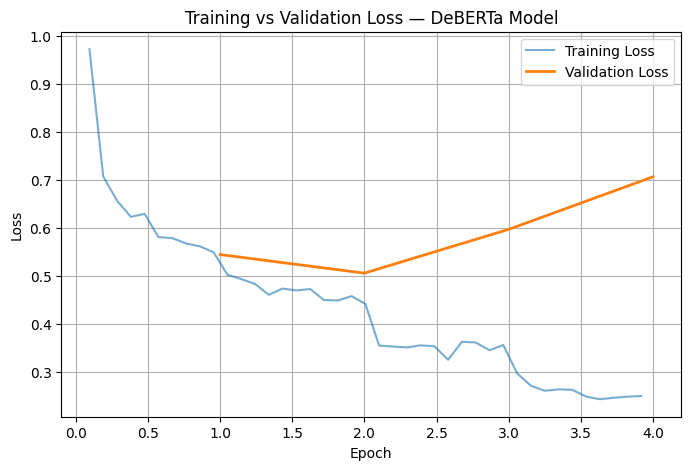

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

log_history = pd.DataFrame(trainer.state.log_history)

train_logs = log_history[log_history["loss"].notnull()]
eval_logs  = log_history[log_history["eval_loss"].notnull()]

plt.figure(figsize=(8,5))
plt.plot(train_logs["epoch"], train_logs["loss"], label="Training Loss", alpha=0.6)
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss — DeBERTa Model")
plt.legend()
plt.grid()
plt.show()


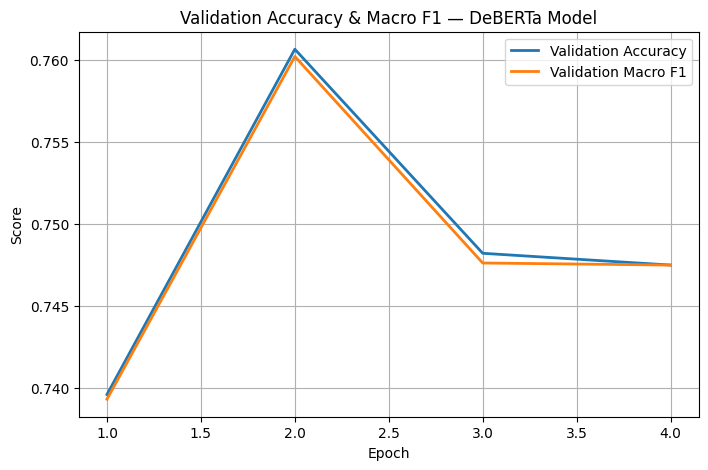

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(eval_logs["epoch"], eval_logs["eval_accuracy"], label="Validation Accuracy", linewidth=2)
plt.plot(eval_logs["epoch"], eval_logs["eval_macro_f1"], label="Validation Macro F1", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Accuracy & Macro F1 — DeBERTa Model")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# CELL SAFE_SAVE — run IMMEDIATELY after training finishes

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import json
import matplotlib.pyplot as plt
import seaborn as sns

print("Running SAFE_SAVE...")

# 1) GET PREDICTIONS
preds_out = trainer.predict(test_ds)

logits = preds_out.predictions
labels = preds_out.label_ids

probs = np.exp(logits - np.max(logits, axis=1, keepdims=True))
probs = probs / probs.sum(axis=1, keepdims=True)
pred_ids = probs.argmax(axis=1)

# 2) BUILD PREDICTIONS DF
out_df = pd.DataFrame(probs, columns=[f"prob_{id2label[i]}" for i in range(len(id2label))])
out_df["pred_id"] = pred_ids
out_df["pred_label"] = [id2label[i] for i in pred_ids]
out_df["true_id"] = labels
out_df["true_label"] = [id2label[i] for i in labels]

pred_path = SAVED_MODELS / "test_predictions_FINAL.csv"
out_df.to_csv(pred_path, index=False)
print("✓ Saved predictions:", pred_path)

# 3) SAVE METRICS
metrics = preds_out.metrics
with open(SAVED_MODELS / "metrics_FINAL.json", "w") as f:
    json.dump(metrics, f, indent=4)
print("✓ Saved metrics:", SAVED_MODELS / "metrics_FINAL.json")

# 4) CONFUSION MATRIX
cm = confusion_matrix(out_df["true_label"], out_df["pred_label"], labels=label_list)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_list, yticklabels=label_list)
plt.title("Confusion Matrix — Final Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(SAVED_MODELS / "confusion_matrix_FINAL.png", dpi=300)
plt.close()
print("✓ Saved confusion matrix")

# 5) CLASSIFICATION REPORT
report = classification_report(out_df["true_label"], out_df["pred_label"], output_dict=True)
pd.DataFrame(report).T.to_csv(SAVED_MODELS / "classification_report_FINAL.csv")
print("✓ Saved classification report")

# 6) SAVE MODEL + TOKENIZER
save_dir = SAVED_MODELS / "text_model_FINAL"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)
print("✓ Saved model and tokenizer to:", save_dir)

print("\nALL DONE — SAFE_SAVE COMPLETED.")


Running SAFE_SAVE...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


✓ Saved predictions: /kaggle/working/models/test_predictions_FINAL.csv
✓ Saved metrics: /kaggle/working/models/metrics_FINAL.json
✓ Saved confusion matrix
✓ Saved classification report
✓ Saved model and tokenizer to: /kaggle/working/models/text_model_FINAL

ALL DONE — SAFE_SAVE COMPLETED.


In [ ]:
# Cell 7 — evaluate and save
import numpy as np, pandas as pd
preds_out = trainer.predict(test_ds)
logits = preds_out.predictions
probs = np.exp(logits - np.max(logits, axis=1, keepdims=True))
probs = probs / probs.sum(axis=1, keepdims=True)
pred_ids = probs.argmax(axis=1)
labels = preds_out.label_ids

out_df = pd.DataFrame(probs, columns=[f"prob_{id2label[i]}" for i in range(len(id2label))])
out_df["pred_id"] = pred_ids
out_df["pred_label"] = [id2label[i] for i in pred_ids]
out_df["true_id"] = labels
out_df["true_label"] = [id2label[i] for i in labels]

out_csv = str(SAVED_MODELS / "test_predictions_deberta_len256.csv")
out_df.to_csv(out_csv, index=False)
print("Saved predictions to", out_csv)
print("Test metrics:", preds_out.metrics)



Saved predictions to /kaggle/working/models/test_predictions_deberta_len256.csv
Test metrics: {'test_loss': 0.5069438219070435, 'test_accuracy': 0.7508361204013378, 'test_macro_f1': 0.7499921225043034, 'test_runtime': 206.3834, 'test_samples_per_second': 20.283, 'test_steps_per_second': 1.269}


In [ ]:
# Cell A — Error analysis for current DeBERTa model
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

pred_path = "/kaggle/working/models/test_predictions_deberta_len256.csv"
df_pred = pd.read_csv(pred_path)

print("Head of predictions:")
print(df_pred.head())

print("\nClassification report (true_label vs pred_label):")
print(classification_report(df_pred["true_label"], df_pred["pred_label"], digits=4))

labels_sorted = sorted(df_pred["true_label"].unique())
cm = confusion_matrix(df_pred["true_label"], df_pred["pred_label"], labels=labels_sorted)
print("\nLabels order:", labels_sorted)
print("Confusion matrix (rows=true, cols=pred):")
print(cm)


Head of predictions:
   prob_mild  prob_minimum  prob_moderate  prob_severe  pred_id pred_label  \
0   0.264660      0.000265       0.000202     0.734872        3     severe   
1   0.985067      0.000214       0.000270     0.014449        0       mild   
2   0.180512      0.000238       0.000164     0.819086        3     severe   
3   0.074733      0.000214       0.000147     0.924906        3     severe   
4   0.196074      0.000270       0.000176     0.803480        3     severe   

   true_id true_label  
0        0       mild  
1        0       mild  
2        3     severe  
3        0       mild  
4        3     severe  

Classification report (true_label vs pred_label):
              precision    recall  f1-score   support

        mild     0.7348    0.7692    0.7516      1066
     minimum     0.7538    0.7953    0.7740      1055
    moderate     0.7758    0.6899    0.7303       948
      severe     0.7451    0.7431    0.7441      1117

    accuracy                         0.7508

In [ ]:
import pandas as pd

summary = pd.DataFrame({
    "Metric": ["Accuracy", "Macro F1"],
    "Value": [
        metrics.get("test_accuracy", None),
        metrics.get("test_macro_f1", None)
    ]
})

display(summary)


,Metric,Value
0,Accuracy,0.750836
1,Macro F1,0.749992


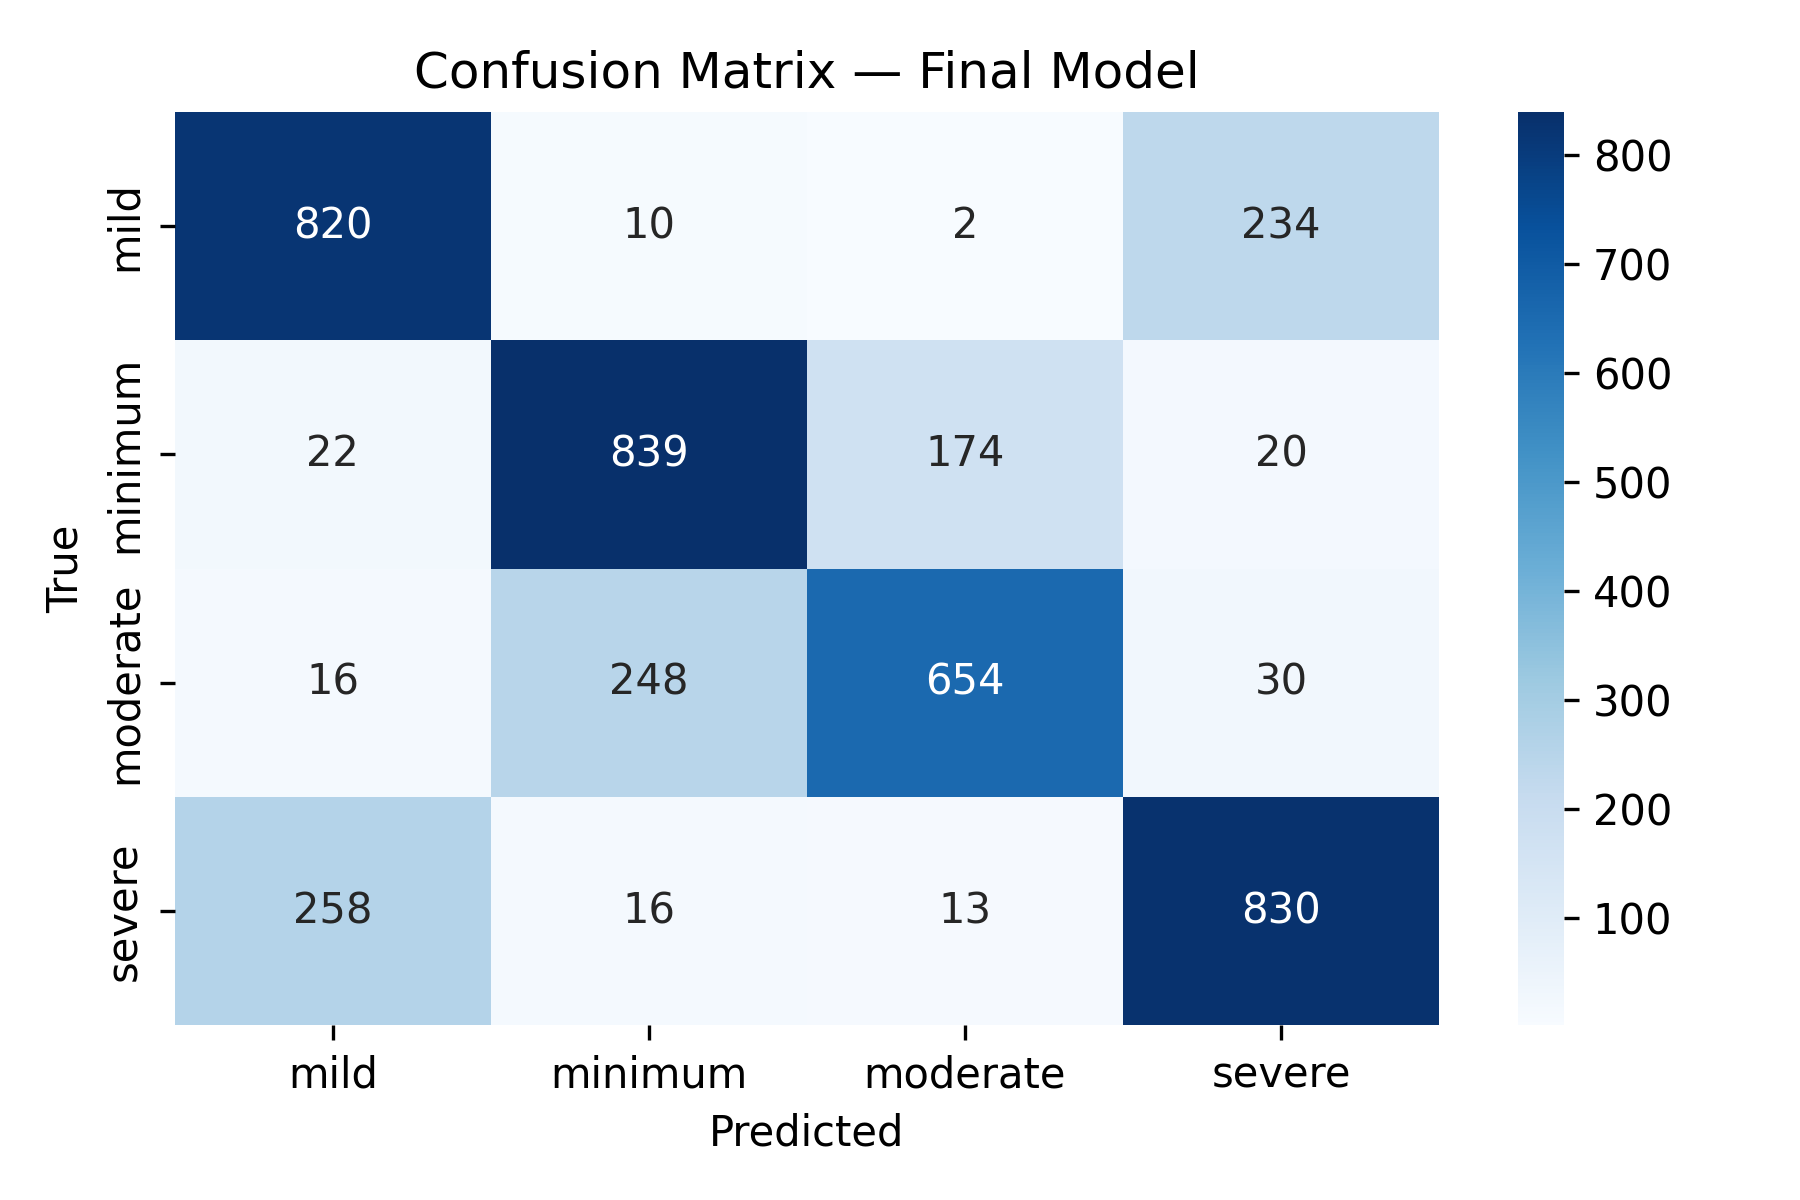

In [ ]:
from IPython.display import Image
Image(filename=str(SAVED_MODELS / "confusion_matrix_FINAL.png"))


In [ ]:
report_df = pd.read_csv(SAVED_MODELS / "classification_report_FINAL.csv")
display(report_df)


,Unnamed: 0,precision,recall,f1-score,support
0,mild,0.734767,0.769231,0.751604,1066.000000
1,minimum,0.753819,0.795261,0.773985,1055.000000
2,moderate,0.775801,0.689873,0.730318,948.000000
3,severe,0.745063,0.743062,0.744061,1117.000000
4,accuracy,0.750836,0.750836,0.750836,0.750836
5,macro avg,0.752362,0.749357,0.749992,4186.000000
6,weighted avg,0.751609,0.750836,0.750411,4186.000000


In [ ]:
import pandas as pd
import json
from pathlib import Path

pred_path = SAVED_MODELS / "test_predictions_FINAL.csv"
metrics_path = SAVED_MODELS / "metrics_FINAL.json"
report_path = SAVED_MODELS / "classification_report_FINAL.csv"

pred_df = pd.read_csv(pred_path)
metrics = json.load(open(metrics_path))
report_df = pd.read_csv(report_path)

print("Loaded files:")
print("Predictions:", pred_path)
print("Metrics:", metrics_path)
print("Classification report:", report_path)

display(metrics)
display(report_df.head())


Loaded files:
Predictions: /kaggle/working/models/test_predictions_FINAL.csv
Metrics: /kaggle/working/models/metrics_FINAL.json
Classification report: /kaggle/working/models/classification_report_FINAL.csv


{'test_loss': 0.5069438219070435,
 'test_accuracy': 0.7508361204013378,
 'test_macro_f1': 0.7499921225043034,
 'test_runtime': 205.9634,
 'test_samples_per_second': 20.324,
 'test_steps_per_second': 1.272}

,Unnamed: 0,precision,recall,f1-score,support
0,mild,0.734767,0.769231,0.751604,1066.000000
1,minimum,0.753819,0.795261,0.773985,1055.000000
2,moderate,0.775801,0.689873,0.730318,948.000000
3,severe,0.745063,0.743062,0.744061,1117.000000
4,accuracy,0.750836,0.750836,0.750836,0.750836


In [ ]:
# Cell T2 — Check per-class difficulty to decide training strategy

from sklearn.metrics import classification_report

print("\nClass difficulty overview:")
report = classification_report(
    df_pred["true_label"],
    df_pred["pred_label"],
    output_dict=True
)

for cls in label_list:
    print(f"{cls:10s} | F1 = {report[cls]['f1-score']:.3f} | Support = {report[cls]['support']}")


In [ ]:
# Run this in one notebook cell (prefix with ! in Python cell or use a %%bash cell)
!pip install --no-cache-dir "protobuf==3.20.3"


In [ ]:
# Cell 8 — install libs for tabular model
!pip install -q xgboost shap


In [ ]:
# Cell 9 — config + load Model B data

import pandas as pd
from pathlib import Path

# Path to the Kaggle dataset (matches the dataset name in your screenshot)
MENTAL_HEALTH_CSV = "/kaggle/input/mentalhealthcalssification/Mental Health Classification.csv"

# We re-use DATA_DIR and SEED and SAVED_MODELS from Cell 1
MODEL_B_DIR = SAVED_MODELS / "model_b_lifestyle"
MODEL_B_DIR.mkdir(parents=True, exist_ok=True)

# Features that correspond to your UI sliders/dropdowns
FEATURES_B = [
    "Gender",
    "Age",
    "SocialMedia_Hours",
    "Sleep_Hours",
    "Nervous_Level",
    "Employment_Status",
]

TARGET_B = "Worsening_Depression"

mh_df = pd.read_csv(MENTAL_HEALTH_CSV)

print("Original shape:", mh_df.shape)
print("Columns:", list(mh_df.columns))

# Keep only the columns we actually use
mh_df = mh_df[FEATURES_B + [TARGET_B]].dropna().reset_index(drop=True)

print("\nAfter sub-select + dropna:", mh_df.shape)
print("\nClass distribution (Worsening_Depression):")
print(mh_df[TARGET_B].value_counts(normalize=True).round(3))
mh_df.head()


Original shape: (1998, 21)
Columns: ['Gender', 'Age', 'Education_Level', 'Employment_Status', 'Depression_Type', 'Symptoms', 'Low_Energy', 'Low_SelfEsteem', 'Search_Depression_Online', 'Worsening_Depression', 'Your overeating level', 'How many times you eat ', 'SocialMedia_Hours', 'SocialMedia_WhileEating', 'Sleep_Hours', 'Nervous_Level', 'Depression_Score', 'Coping_Methods', 'Self_Harm', 'Mental_Health_Support', 'Suicide_Attempts']

After sub-select + dropna: (1998, 7)

Class distribution (Worsening_Depression):
Worsening_Depression
1    0.652
0    0.348
Name: proportion, dtype: float64


,Gender,Age,SocialMedia_Hours,Sleep_Hours,Nervous_Level,Employment_Status,Worsening_Depression
0,1,25,10,10,10,3,1
1,1,25,8,4,10,2,1
2,1,25,10,4,10,3,1
3,0,25,4,3,10,2,1
4,1,25,3,7,1,2,0


In [ ]:
# Cell 10 — train/val/test split for Model B

from sklearn.model_selection import train_test_split

X = mh_df[FEATURES_B]
y = mh_df[TARGET_B].astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=SEED,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=SEED,
)

print("Train/Val/Test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])


Train/Val/Test sizes: 1598 200 200


In [ ]:
# Cell 11 — XGBoost with RandomizedSearchCV for max accuracy (no gpu_hist warnings)

import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score

# OPTION 1 (recommended for small Kaggle tabular datasets): just use CPU
use_gpu = False   # <- set to False to silence all GPU warnings and keep life simple

# If you really want GPU, set use_gpu = True
if use_gpu:
    device = "cuda"
else:
    device = "cpu"

print("Using device:", device)

xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",   # new recommended tree method
    device=device,        # "cuda" or "cpu"
    use_label_encoder=False,
    random_state=SEED,
)

param_dist = {
    "n_estimators":     [100, 200, 400, 600],
    "max_depth":        [3, 4, 5, 6],
    "learning_rate":    [0.01, 0.05, 0.1, 0.2],
    "subsample":        [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 5, 10],
    "gamma":            [0, 0.1, 0.3, 0.5],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=40,              # increase for more aggressive tuning
    scoring="accuracy",
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=SEED,
)

search.fit(X_train, y_train)

print("\nBest CV accuracy:", search.best_score_)
print("Best params:", search.best_params_)

model_b = search.best_estimator_

# quick validation accuracy
val_pred = model_b.predict(X_val)
val_acc = accuracy_score(y_val, val_pred)
print("Validation accuracy of tuned Model B:", val_acc)


Using device: cpu
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best CV accuracy: 0.8429094827586209
Best params: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.7}
Validation accuracy of tuned Model B: 0.815


In [ ]:
# Cell 12 — evaluate on test set, then retrain on train+val

from sklearn.metrics import classification_report, confusion_matrix

# Evaluate on held-out test set first
test_pred = model_b.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
print("Test accuracy (Model B):", test_acc)
print("\nClassification report:\n", classification_report(y_test, test_pred))

print("\nConfusion matrix (rows=true, cols=pred):\n", confusion_matrix(y_test, test_pred))

# Retrain the best model on Train + Val for deployment
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

model_b.fit(X_train_full, y_train_full)

# Sanity check: accuracy on full training set (just to see if it overfits badly)
train_full_pred = model_b.predict(X_train_full)
print("\nFull Train accuracy after refit:", accuracy_score(y_train_full, train_full_pred))


Test accuracy (Model B): 0.815

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.61      0.70        70
           1       0.82      0.92      0.87       130

    accuracy                           0.81       200
   macro avg       0.81      0.77      0.78       200
weighted avg       0.81      0.81      0.81       200


Confusion matrix (rows=true, cols=pred):
 [[ 43  27]
 [ 10 120]]

Full Train accuracy after refit: 0.8553948832035595


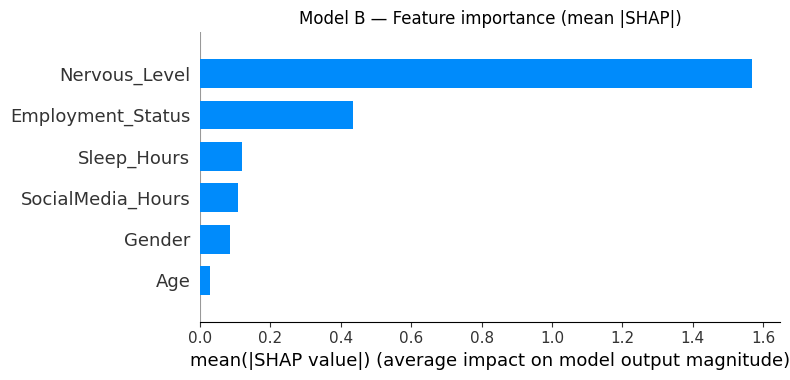

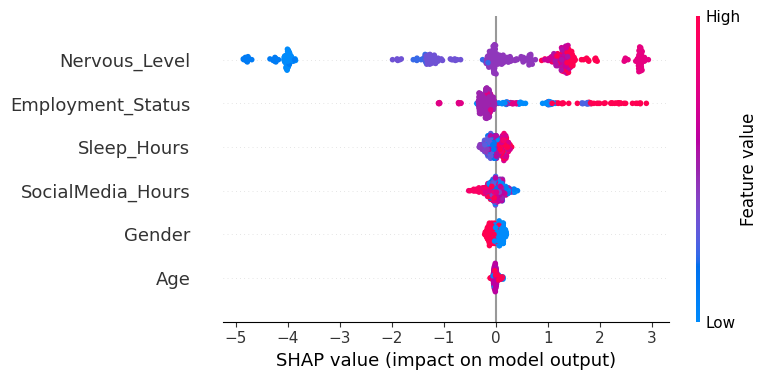

In [ ]:
# Cell 13 — SHAP feature importance & explanations for Model B

import shap
import matplotlib.pyplot as plt

# Initialize JS for notebook (nice in Kaggle)
shap.initjs()

# Use a sample to keep plots fast
sample_size = min(500, X_train_full.shape[0])
X_sample = X_train_full.sample(sample_size, random_state=SEED)

explainer = shap.TreeExplainer(model_b)
shap_values = explainer.shap_values(X_sample)

# For binary XGBoost, shap_values can be (n, features) or list of length 2
if isinstance(shap_values, list):
    # take SHAP values for the "1" class (worsening trend)
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

# 1) Bar plot of mean |SHAP| = global importance
plt.title("Model B — Feature importance (mean |SHAP|)")
shap.summary_plot(shap_values_to_plot, X_sample, plot_type="bar", show=False)
plt.show()

# 2) Detailed summary plot (distribution per feature)
shap.summary_plot(shap_values_to_plot, X_sample)


In [ ]:
# Cell R3 — Model B Summary & SHAP Figure Export (for README)

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Accuracy summary
print("Model B Test Accuracy:", test_acc)

# Export SHAP bar plot to PNG for README
plt.figure()
shap.summary_plot(shap_values_to_plot, X_sample, plot_type="bar", show=False)
plt.title("Model B — Feature Importance (mean |SHAP|)")
plt.savefig(str(MODEL_B_DIR / "shap_importance.png"), dpi=300, bbox_inches='tight')
plt.close()

print("SHAP importance plot saved to:", MODEL_B_DIR / "shap_importance.png")


Model B Test Accuracy: 0.815
SHAP importance plot saved to: /kaggle/working/models/model_b_lifestyle/shap_importance.png


In [ ]:
# Cell 14 — save Model B artifacts

import joblib
import json

model_b_path = MODEL_B_DIR / "xgboost_model_b.pkl"
features_b_path = MODEL_B_DIR / "model_b_features.json"

joblib.dump(model_b, model_b_path)
with open(features_b_path, "w") as f:
    json.dump(FEATURES_B, f)

print("Saved Model B to:", model_b_path)
print("Saved feature list to:", features_b_path)


Saved Model B to: /kaggle/working/models/model_b_lifestyle/xgboost_model_b.pkl
Saved feature list to: /kaggle/working/models/model_b_lifestyle/model_b_features.json


In [ ]:
# ============================================
# FINAL PRODUCT TEST — MODEL A + MODEL B
# ============================================

import json
import torch
import pandas as pd
import joblib
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ------------------------------------------------
# 1. Load Model A — DeBERTa (Text Depression Level)
# ------------------------------------------------

# THIS IS THE CORRECT FINAL MODEL DIRECTORY
MODEL_A_DIR = "/kaggle/working/models/text_model_FINAL"

tokenizer_a = AutoTokenizer.from_pretrained(
    MODEL_A_DIR,
    local_files_only=True
)

model_a = AutoModelForSequenceClassification.from_pretrained(
    MODEL_A_DIR,
    local_files_only=True
)
model_a.eval()

label_map_a = model_a.config.id2label


def predict_text_depression(text):
    tokens = tokenizer_a(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=256
    )

    with torch.no_grad():
        logits = model_a(**tokens).logits

    probs = torch.softmax(logits, dim=1).numpy()[0]
    pred_id = int(np.argmax(probs))
    pred_label = label_map_a[pred_id]

    return pred_label, probs


# ------------------------------------------------
# 2. Load Model B — XGBoost Lifestyle Model
# ------------------------------------------------

MODEL_B_DIR = "/kaggle/working/models/model_b_lifestyle"

model_b = joblib.load(f"{MODEL_B_DIR}/xgboost_model_b.pkl")

with open(f"{MODEL_B_DIR}/model_b_features.json", "r") as f:
    FEATURE_LIST_B = json.load(f)


def predict_lifestyle_risk(features_dict):
    df = pd.DataFrame([features_dict], columns=FEATURE_LIST_B)
    pred = int(model_b.predict(df)[0])
    prob = float(model_b.predict_proba(df)[0][1])
    return pred, prob


# ------------------------------------------------
# 3. Test Example — Full Product
# ------------------------------------------------

sample_text = """
i have something been hiding on my parents for 3 years my grades in uni i told them that my grades are
fine when in reality they are trash i cant get the thought out of my head i think about it all time
and iam not ready at all the when the time comes and i will have to face them.
"""

sample_features = {
    "Gender": 1,
    "Age": 22,
    "SocialMedia_Hours": 5,
    "Sleep_Hours": 8,
    "Nervous_Level": 7,
    "Employment_Status": 2
}

# Run Text Model (A)
label_a, probs_a = predict_text_depression(sample_text)

# Run Lifestyle Model (B)
label_b, prob_b = predict_lifestyle_risk(sample_features)

# ------------------------------------------------
# 4. Final Output
# ------------------------------------------------

print("=== FULL PRODUCT TEST ===\n")

print("Model A — Text Depression Level")
print("--------------------------------")
print("Predicted Level:", label_a)
print("Probabilities:", probs_a, "\n")

print("Model B — Lifestyle Risk Model")
print("--------------------------------")
print("Worsening Risk (0=no, 1=yes):", label_b)
print("Probability of worsening:", prob_b)


=== FULL PRODUCT TEST ===

Model A — Text Depression Level
--------------------------------
Predicted Level: severe
Probabilities: [6.1018553e-02 7.5691083e-04 4.2643529e-04 9.3779814e-01] 

Model B — Lifestyle Risk Model
--------------------------------
Worsening Risk (0=no, 1=yes): 1
Probability of worsening: 0.8149287700653076


In [ ]:
!cp -r /kaggle/working/models/text_model_FINAL /kaggle/working/text_model_FINAL


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
!zip -r text_model_FINAL.zip /kaggle/working/models/text_model_FINAL


  adding: kaggle/working/models/text_model_FINAL/ (stored 0%)
  adding: kaggle/working/models/text_model_FINAL/added_tokens.json (stored 0%)
  adding: kaggle/working/models/text_model_FINAL/training_args.bin (deflated 51%)
  adding: kaggle/working/models/text_model_FINAL/spm.model

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 50%)
  adding: kaggle/working/models/text_model_FINAL/tokenizer.json (deflated 77%)
  adding: kaggle/working/models/text_model_FINAL/config.json (deflated 55%)
  adding: kaggle/working/models/text_model_FINAL/tokenizer_config.json (deflated 74%)
  adding: kaggle/working/models/text_model_FINAL/special_tokens_map.json (deflated 50%)
  adding: kaggle/working/models/text_model_FINAL/model.safetensors (deflated 13%)
